In [312]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [313]:
train = pd.read_csv('../input/train.csv', index_col='Id')
test = pd.read_csv('../input/test.csv', index_col='Id')

In [314]:
# constants
SKEW = 0.2

In [315]:
from scipy.stats import skew
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

train["SalePrice"] = np.log1p(train["SalePrice"])

In [316]:
# new feature: Valid Area
flrArea = all_data['1stFlrSF'] + all_data['2ndFlrSF']
validArea = flrArea + 0.7 * all_data.TotalBsmtSF + all_data.GarageArea
all_data['validArea'] = validArea

In [317]:
object_feats = all_data.dtypes[all_data.dtypes == object].index
all_data[object_feats] = all_data[object_feats].fillna('NA')

In [318]:
all_data.OverallQual.shape

(2919,)

In [319]:
# new feature: quality / condition score
qual = ['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual']
cond = ['ExterCond', 'BsmtCond', 'GarageCond']
train_qual = all_data[qual]
train_cond = all_data[cond]

grade = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NA' : 0}
train_qual = train_qual.apply(lambda x : x.map(grade))
train_cond = train_cond.apply(lambda x : x.map(grade))

cond_qual = train_qual.join(train_cond).join(all_data.OverallCond).join(all_data.OverallQual)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(cond_qual.iloc[:train.shape[0]], np.log1p(train_df.SalePrice))
cond_qual_score = lr.predict(cond_qual)
all_data['Cond_Qual_score'] = cond_qual_score

In [320]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index


skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > SKEW]
skewed_feats = skewed_feats.index


all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [321]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [322]:
from sklearn.cross_validation import cross_val_score

def rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y=y, scoring='mean_squared_error'))
    return rmse.mean()

def get_result(model, desc):
    y_pred = np.expm1(model.predict(test_df.values))
    output_name = '../output/' + desc + '.csv'
    output(output_name, y_pred)

def output(path, y_pred):
    out_df = pd.DataFrame(y_pred, index=test_df.index, columns=['SalePrice'])
    out_df.to_csv(path)

In [323]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 313 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(307), int64(6)
memory usage: 3.5 MB


In [349]:
from sklearn.ensemble import RandomForestRegressor

rf = ExtraTreesRegressor(n_estimators=100)
rf.fit(X_train, np.log1p(train.SalePrice))
importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

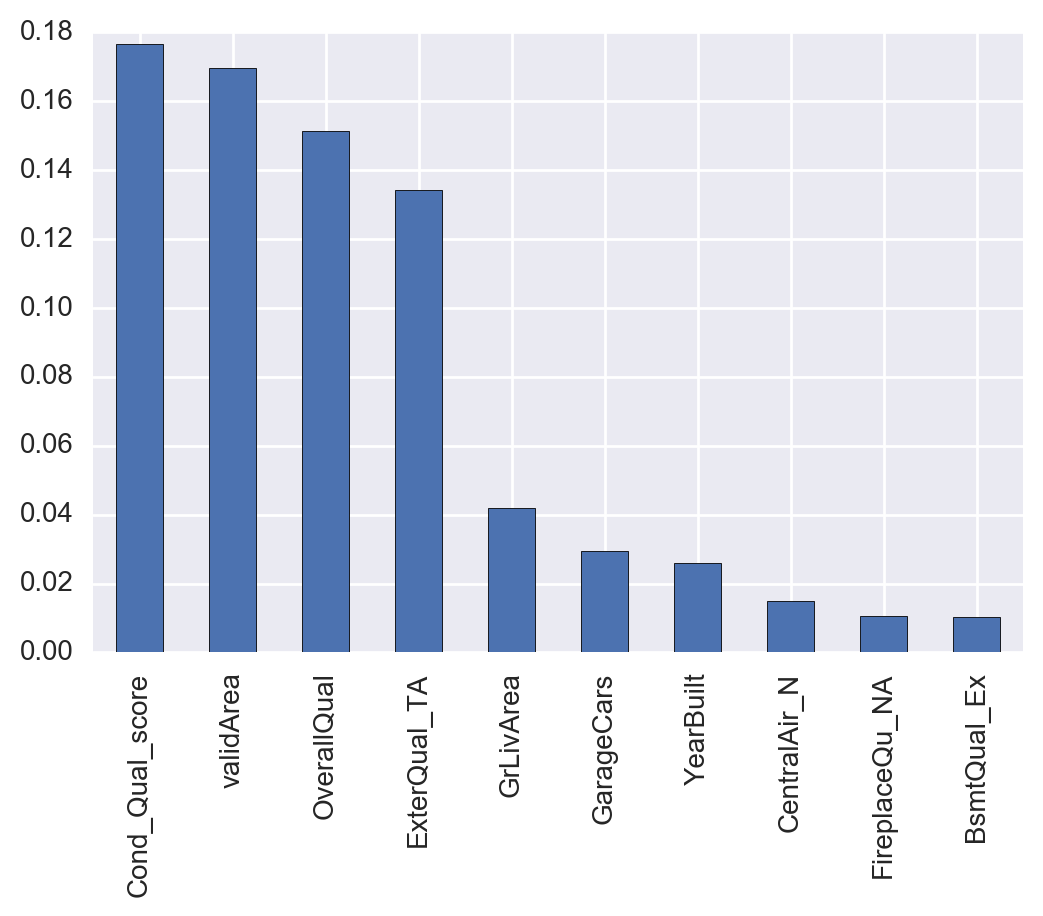

In [353]:
importance.iloc[:10].plot(kind='bar')

In [354]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0004)

model = lasso

rmse(model)

0.12273719604453807

In [363]:
from sklearn.ensemble import GradientBoostingRegressor

gbdt = GradientBoostingRegressor(n_estimators=400, \
                                 max_depth=4, \
                                 max_features=50,)

rmse(gbdt)

0.12661644117179938

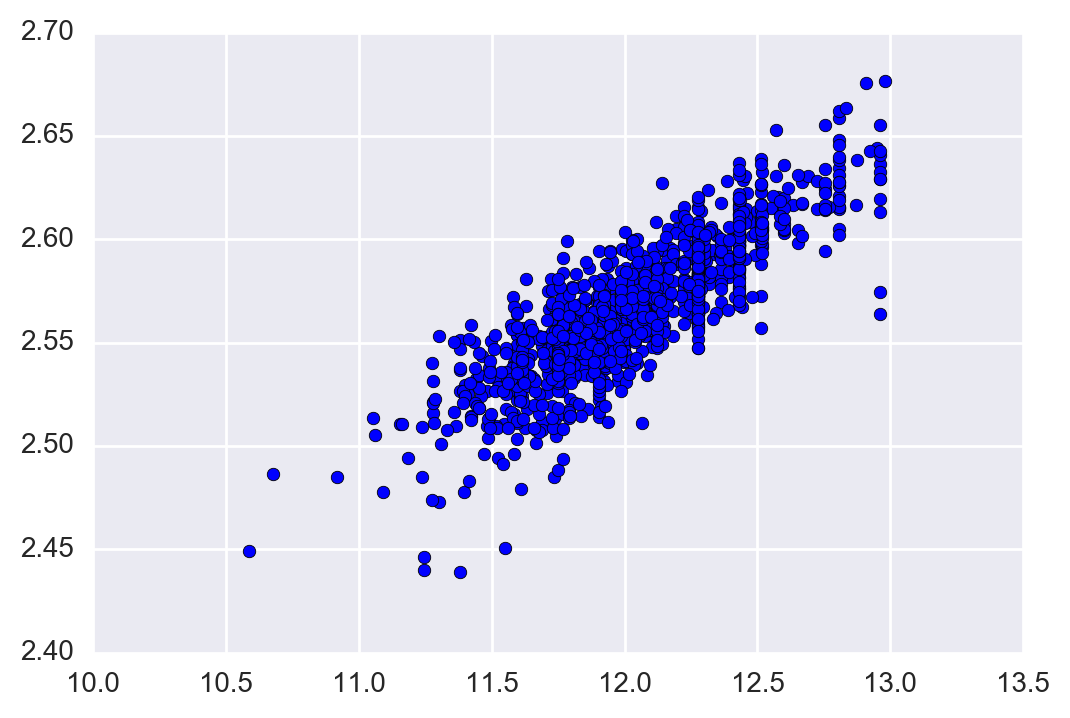

In [342]:
plt.scatter(X_train.Cond_Qual_score, np.log1p(train.SalePrice))

In [338]:
a = lasso.fit(X_train, y)
coef = pd.Series(a.coef_, index=all_data.columns)
coef.sort_values(ascending=False)
coef.Cond_Qual_score

0.0

In [123]:
test.index

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919],
           dtype='int64', name=u'Id', length=1459)

In [124]:
### prediction
model.fit(X_train, y)

preds = np.expm1(model.predict(X_test))
solution = pd.DataFrame({"Id":test.index, "SalePrice":preds})
solution.to_csv("../output/valid_area.csv", index = False)
